In [2]:
from geopy.geocoders import Nominatim
import pandas as pd
import time

geolocator = Nominatim(user_agent="smoothie_locator")
df = pd.read_csv("data.csv")

def geocode_address(addr):
    try:
        location = geolocator.geocode(f"{addr}, Zürich, Switzerland")
        return (location.latitude, location.longitude)
    except:
        return (None, None)

# Apply geocoding
df[['lat', 'lon']] = df['address'].apply(
    lambda x: pd.Series(geocode_address(x))
)

time.sleep(1)  # to respect rate limits

In [3]:
print(df)

                           name                area  rating  reviews  \
0                    Juicery 21             Kreis 3     4.6      345   
1                         Roots     Kreis 8 Seefeld     4.5      198   
2                    Haus Hiltl             Kreis 1     4.5     2156   
3                        Tibits     Kreis 8 Seefeld     4.4     1247   
4                  Juice Attack             Kreis 1     4.3      287   
5                        Yoojis             Kreis 6     4.2      345   
6                  Dean & David             Kreis 4     4.1      456   
7                          Ooki             Kreis 1     4.0      267   
8               Joe & the Juice             Kreis 1     3.9      523   
9      Joe & the Juice Sihlcity             Kreis 3     3.8      298   
10              Fresh & Friends             Kreis 1     3.8      623   
11                     Saftlade  Kreis 1 Niederdorf     4.2      156   
12                      U-Juice             Kreis 1     4.0     

In [5]:
from keys import API_KEY_PLACES
import requests
import pandas as pd
import time

# 🔍 Search parameters
location = "47.3769,8.5417"  # Zurich center
radius = 5000  # meters
keyword = "smoothie"

def fetch_places(api_key, location, radius, keyword):
    all_results = []
    url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
    params = {
        "location": location,
        "radius": radius,
        "keyword": keyword,
        "key": api_key
    }

    while True:
        res = requests.get(url, params=params)
        data = res.json()

        if "results" in data:
            all_results.extend(data["results"])

        # Handle pagination
        if "next_page_token" in data:
            time.sleep(2)  # required by Google
            params = {
                "pagetoken": data["next_page_token"],
                "key": api_key
            }
        else:
            break

    return all_results

def process_places(results):
    data = []
    for place in results:
        data.append({
            "name": place.get("name"),
            "address": place.get("vicinity"),
            "lat": place["geometry"]["location"]["lat"],
            "lon": place["geometry"]["location"]["lng"],
            "rating": place.get("rating"),
            "reviews": place.get("user_ratings_total"),
            "place_id": place.get("place_id")  # 🔑 Add place ID for later
        })
    return pd.DataFrame(data)

# 🚀 Run everything
places = fetch_places(API_KEY_PLACES, location, radius, keyword)
df_places = process_places(places)

# 💾 Save to file
df_places.to_csv("zurich_smoothie_places_with_ids.csv", index=False)
print("✅ Saved to zurich_smoothie_places_with_ids.csv")

✅ Saved to zurich_smoothie_places_with_ids.csv


In [6]:
from keys import API_KEY_PLACES
import requests
import pandas as pd
import time

# Load the place_id data
df_places = pd.read_csv("zurich_smoothie_places_with_ids.csv")

# Helper function to fetch reviews for one place
def get_reviews_for_place(place_id):
    url = "https://maps.googleapis.com/maps/api/place/details/json"
    params = {
        "place_id": place_id,
        "fields": "review",
        "key": API_KEY_PLACES
    }

    res = requests.get(url, params=params)
    data = res.json()

    reviews = data.get("result", {}).get("reviews", [])
    smoothie_reviews = []

    for review in reviews:
        text = review.get("text", "").lower()
        if "smoothie" in text:
            smoothie_reviews.append({
                "place_id": place_id,
                "author": review.get("author_name"),
                "rating": review.get("rating"),
                "time": review.get("relative_time_description"),
                "text": review.get("text")
            })

    return smoothie_reviews

# Extract reviews for each place
all_smoothie_reviews = []

for idx, row in df_places.iterrows():
    place_id = row["place_id"]
    try:
        reviews = get_reviews_for_place(place_id)
        all_smoothie_reviews.extend(reviews)
        print(f"✅ Got {len(reviews)} reviews for {row['name']}")
        time.sleep(1)  # To respect API rate limits
    except Exception as e:
        print(f"❌ Error for {place_id}: {e}")
        continue

# Convert to DataFrame
df_reviews = pd.DataFrame(all_smoothie_reviews)

# Save the result
df_reviews.to_csv("smoothie_keyword_reviews.csv", index=False)
print("✅ Saved smoothie reviews to smoothie_keyword_reviews.csv")

✅ Got 1 reviews for Juicery 21
✅ Got 4 reviews for Honest Smoothies
✅ Got 0 reviews for Blooming Juice
✅ Got 0 reviews for JOE & THE JUICE
✅ Got 1 reviews for Dabo Smoothies
✅ Got 2 reviews for JOE & THE JUICE
✅ Got 1 reviews for JOE & THE JUICE
✅ Got 0 reviews for JOE & THE JUICE
✅ Got 0 reviews for JOE & THE JUICE
✅ Got 0 reviews for Wild Bowls
✅ Got 0 reviews for Daily Fresh
✅ Got 2 reviews for Oakberry
✅ Got 0 reviews for JOE & THE JUICE
✅ Got 1 reviews for JOE & THE JUICE
✅ Got 1 reviews for bloom society
✅ Got 0 reviews for Bang-On Tapiocaria & Açaí
✅ Got 0 reviews for HITZBERGER HB Halle Löwenstrasse
✅ Got 0 reviews for Roots
✅ Got 1 reviews for Wild Bowls Seefeld
✅ Got 0 reviews for Dean & David
✅ Got 0 reviews for Klara's kitchen
✅ Got 0 reviews for BEETNUT
✅ Got 0 reviews for C.R.E.A.M Coffee Bar Food.
✅ Got 0 reviews for Coop Pronto Shop Zürich-Stettbach Bahnhof
✅ Got 0 reviews for Coop Supermarkt Zürich Kreuzplatz
✅ Got 0 reviews for migrolino Triemli
✅ Got 0 reviews for Co

In [8]:
import pandas as pd
from textblob import TextBlob

# Load reviews
df = pd.read_csv("smoothie_keyword_reviews.csv")

# Calculate sentiment score
def get_sentiment(text):
    if pd.isna(text) or not isinstance(text, str):
        return None
    return TextBlob(text).sentiment.polarity  # Range: -1 (negative) to +1 (positive)

df["sentiment"] = df["text"].apply(get_sentiment)

# Save updated CSV
df.to_csv("smoothie_reviews_with_sentiment.csv", index=False)
print("✅ Sentiment column added and file saved to: smoothie_reviews_with_sentiment.csv")

✅ Sentiment column added and file saved to: smoothie_reviews_with_sentiment.csv


/var/folders/sf/3_6zfybs6_xcm9ncfcfxk_zr0000gn/T/ipykernel_98263/2906791499.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(grouped["time"], rotation=45, ha="right")


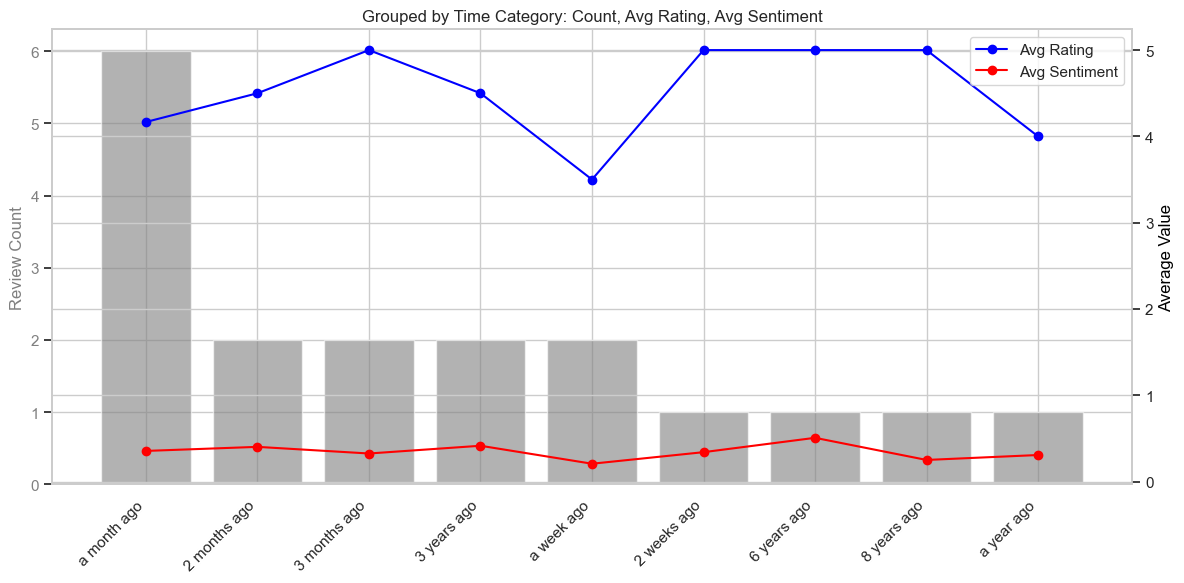

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("smoothie_reviews_with_sentiment.csv")

# Group by original 'time' column
grouped = df.groupby("time").agg(
    count=("rating", "count"),
    avg_rating=("rating", "mean"),
    avg_sentiment=("sentiment", "mean")
).reset_index()

# Sort by count (optional, for clearer plots)
grouped = grouped.sort_values(by="count", ascending=False)

# Display
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot: counts
ax1.bar(grouped["time"], grouped["count"], alpha=0.6, label="Review Count", color="gray")
ax1.set_ylabel("Review Count", color="gray")
ax1.tick_params(axis='y', labelcolor='gray')
ax1.set_xticklabels(grouped["time"], rotation=45, ha="right")

# Line plot: avg rating
ax2 = ax1.twinx()
ax2.plot(grouped["time"], grouped["avg_rating"], label="Avg Rating", color="blue", marker="o")
ax2.plot(grouped["time"], grouped["avg_sentiment"], label="Avg Sentiment", color="red", marker="o")
ax2.set_ylabel("Average Value", color="black")
ax2.tick_params(axis='y')

plt.title("Grouped by Time Category: Count, Avg Rating, Avg Sentiment")
fig.tight_layout()
ax2.legend(loc="upper right")
plt.show()

In [7]:
from keys import API_KEY_PLACES
import requests
import pandas as pd
import time

# Load your places with place_ids
df_places = pd.read_csv("zurich_smoothie_places_with_ids.csv")

# Function to fetch all reviews for one place (no filter)
def get_all_reviews(place_id):
    url = "https://maps.googleapis.com/maps/api/place/details/json"
    params = {
        "place_id": place_id,
        "fields": "review",
        "key": API_KEY_PLACES
    }

    res = requests.get(url, params=params)
    data = res.json()

    reviews = data.get("result", {}).get("reviews", [])
    output = []

    for review in reviews:
        output.append({
            "place_id": place_id,
            "author": review.get("author_name"),
            "rating": review.get("rating"),
            "time": review.get("relative_time_description"),
            "text": review.get("text")
        })

    return output

# Loop through all places and collect reviews
all_reviews = []

for idx, row in df_places.iterrows():
    place_id = row["place_id"]
    try:
        reviews = get_all_reviews(place_id)
        all_reviews.extend(reviews)
        print(f"✅ Collected {len(reviews)} reviews for {row['name']}")
        time.sleep(1)  # Respect rate limits
    except Exception as e:
        print(f"❌ Error fetching reviews for {place_id}: {e}")
        continue

# Convert to DataFrame
df_all_reviews = pd.DataFrame(all_reviews)

# Optional: join with place names
df_all_reviews = df_all_reviews.merge(df_places[["place_id", "name", "address"]], on="place_id", how="left")

# Save to CSV
df_all_reviews.to_csv("all_reviews_zurich_smoothie_places.csv", index=False)
print("✅ All reviews saved to all_reviews_zurich_smoothie_places.csv")

✅ Collected 5 reviews for Juicery 21
✅ Collected 5 reviews for Honest Smoothies
✅ Collected 5 reviews for Blooming Juice
✅ Collected 5 reviews for JOE & THE JUICE
✅ Collected 5 reviews for Dabo Smoothies
✅ Collected 5 reviews for JOE & THE JUICE
✅ Collected 5 reviews for JOE & THE JUICE
✅ Collected 5 reviews for JOE & THE JUICE
✅ Collected 5 reviews for JOE & THE JUICE
✅ Collected 5 reviews for Wild Bowls
✅ Collected 5 reviews for Daily Fresh
✅ Collected 5 reviews for Oakberry
✅ Collected 5 reviews for JOE & THE JUICE
✅ Collected 5 reviews for JOE & THE JUICE
✅ Collected 5 reviews for bloom society
✅ Collected 5 reviews for Bang-On Tapiocaria & Açaí
✅ Collected 5 reviews for HITZBERGER HB Halle Löwenstrasse
✅ Collected 5 reviews for Roots
✅ Collected 5 reviews for Wild Bowls Seefeld
✅ Collected 5 reviews for Dean & David
✅ Collected 5 reviews for Klara's kitchen
✅ Collected 5 reviews for BEETNUT
✅ Collected 5 reviews for C.R.E.A.M Coffee Bar Food.
✅ Collected 5 reviews for Coop Pronto 